#    Zillow Logerror Estimation Model


## Project Goals
1. create a model that can predict error in Zestimated values

2. from that model, identify key features driving logerror

3. clearly communicate finding to classmates

## Project Requirements
1. utilize clustering algorithms at some point in the pipeline

2. utilize statistical testing to identify key features

3. provide helpful visulatizations explaining exploration process

4. use scaling methods on data and document why they we're used

5. impute missing values and document

6. encode cateorical data

7. feature engineering and document rational behind it


### 0. Imports

In [1]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")

#python libraries used
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

#sklearn
from sklearn.impute import SimpleImputer

#project specific functions
import acquire
import summarize
import prepare
import explore
import modeling
import cluster
from env import host,password,user



### I. Acquisition

Get data on homes sold in 2017 with recorded Latitude and Longitude

In [ ]:
# #mysql query
# query = '''
#     SELECT prop.*, pred.logerror, pred.transactiondate
#     FROM predictions_2017 AS pred
#     LEFT JOIN properties_2017 AS prop  USING(parcelid)
#     WHERE (bedroomcnt > 0 AND bathroomcnt > 0 AND calculatedfinishedsquarefeet > 500 AND latitude IS NOT NULL AND longitude IS NOT NULL) 
#     AND (unitcnt = 1 OR unitcnt IS NULL)
#     ;
#     '''
# db_name = 'zillow'
# #get data from database
# zillow = pd.read_sql(query, f"mysql+pymysql://{user}:{password}@{host}/{db_name}")
# print(f'Data frame shape:\nrows: {zillow.shape[0]}\ncolumns: {zillow.shape[1]}')

In [2]:
zillow = pd.read_csv('data.csv')

## II. Preparation

Standardize all null values to *np.nan*

In [3]:
zillow.fillna(value=pd.np.nan, inplace=True)

Add some features I think will be significant

In [4]:
zillow['has_basement'] = zillow.basementsqft > 0
zillow['has_fireplace'] = zillow.fireplacecnt > 0
zillow['has_deck'] = ~zillow.decktypeid.isna()
zillow['has_garage'] = zillow.garagetotalsqft > 0
zillow['has_pool_or_spa'] = (zillow.hashottuborspa == 1) | (zillow.poolcnt> 0)
zillow['has_yardbuilding'] = (zillow.yardbuildingsqft17) > 0 | (zillow.yardbuildingsqft26 > 0)
zillow['multistory'] = zillow.numberofstories > 1

In [5]:
print(f'Data frame has:\nrows: {zillow.shape[0]}\ncolumns: {zillow.shape[1]}')

Data frame has:
rows: 73424
columns: 68


Drop columns that are missing over 25% of their data and rows that are missing over 60% 

In [6]:
zillow = prepare.handle_missing_values(zillow, prop_required_column= .25, prop_required_row=.60)
print(f'Data frame now has:\nrows: {zillow.shape[0]}\ncolumns: {zillow.shape[1]}')
print("No rows were dropped using this criteria.")

Data frame now has:
rows: 73424
columns: 43
No rows were dropped using this criteria.


Now we can clean up column names

In [7]:
zillow.rename(columns = {
    'parcelid': 'parcel_id',
    'airconditioningtypeid': 'ac_type_id',
    'bathroomcnt': 'bathroom_cnt',
    'bedroomcnt': 'bedroom_cnt',
    'buildingqualitytypeid': 'building_quality_type',
    'calculatedbathnbr': 'sum_bath_and_bed',
    'calculatedfinishedsquarefeet': 'square_feet',
    'fips': 'fips_code',
    'fullbathcnt': 'full_bath_cnt',
    'garagecarcnt': 'garage_car_cnt',
    'garagetotalsqft': 'garage_sqr_ft',
    'heatingorsystemtypeid': 'heating_type_id',
    'lotsizesquarefeet': 'lot_sqr_ft',
    'propertycountylandusecode': 'property_land_use_code',
    'propertylandusetypeid': 'property_land_use_id',
    'propertyzoningdesc': 'property_zoning',
    'rawcensustractandblock': 'raw_census_block',
    'regionidcity': 'city_id',
    'regionidcounty': 'county_id',
    'regionidneighborhood': 'neighborhood_id',
    'regionidzip': 'zipcode_id',
    'roomcnt': 'room_cnt',
    'unitcnt': 'unit_cnt',
    'yearbuilt': 'year_built',
    'structuretaxvaluedollarcnt': 'building_value',
    'taxvaluedollarcnt': 'total_value',
    'assessmentyear': 'year_assessed',
    'landtaxvaluedollarcnt': 'land_value',
    'taxamount': 'tax_amount',
    'censustractandblock': 'census_block',
    'transactiondate': 'transaction_date'
    }, inplace= True)
zillow.head()

,id,parcel_id,ac_type_id,bathroom_cnt,bedroom_cnt,building_quality_type,sum_bath_and_bed,square_feet,finishedsquarefeet12,fips_code,...,census_block,logerror,transaction_date,has_basement,has_fireplace,has_deck,has_garage,has_pool_or_spa,has_yardbuilding,multistory
0,1727539,14297519,NaN,3.5,4.0,NaN,3.5,3100.0,3100.0,6059.0,...,6.059063e+13,0.025595,2017-01-01,False,False,False,True,False,False,False
1,1387261,17052889,NaN,1.0,2.0,NaN,1.0,1465.0,1465.0,6111.0,...,6.111001e+13,0.055619,2017-01-01,False,True,False,False,False,False,False
2,11677,14186244,NaN,2.0,3.0,NaN,2.0,1243.0,1243.0,6059.0,...,6.059022e+13,0.005383,2017-01-01,False,False,False,True,True,False,False
3,2288172,12177905,NaN,3.0,4.0,8.0,3.0,2376.0,2376.0,6037.0,...,6.037300e+13,-0.103410,2017-01-01,False,False,False,False,True,False,False
4,1970746,10887214,1.0,3.0,3.0,8.0,3.0,1312.0,1312.0,6037.0,...,6.037124e+13,0.006940,2017-01-01,False,False,False,False,True,False,False


### Dataframe Cleaning
- drop redundant columns
     
- drop columns with no variance (single values columns)
- change build year measure to house age and drop year_built
- divide latitude and longitude by a factor of 6
- dropping building quality type because it has no reference
- impute missing values

**Redundant Columns**
1. raw_census_block and census_block hold the same information
2. county_id and fips_id hold the same information
3. garage_car_cnt and garage_sqr_ft are replaced with has_garage     

In [8]:
zillow.drop(columns = 'raw_census_block', inplace= True)
zillow.drop(columns = 'county_id', inplace= True)
zillow.drop(columns = ['garage_sqr_ft', 'garage_car_cnt'], inplace= True)

**Columns with no Variance**
- unit_cnt and year_assessed
    

In [9]:
zillow.drop(columns = ['year_assessed', 'unit_cnt'], inplace= True)

**Edit Columns**
- Build year can be scaled reasonably by computing house age from date of assesment and replacing

In [10]:
zillow['home_age'] = 2016 - zillow.year_built
zillow.drop(columns = 'year_built', inplace= True)

- Latitude and Longitude should be more useful for plotting if we shorten them.

In [11]:
zillow['latitude'] = zillow.latitude/(10^6)
zillow['longitude'] = zillow.longitude/(10^6)

- building quality type is getting dropped because it's meaning isn't listed anywhere

In [12]:
zillow.drop(columns = 'building_quality_type', inplace=True)

**impute missing values**
- If a column has > 1,000 missing values, we'll consider imputing
- If a column has too many unique values and too many missing rows, we'll drop it

In [13]:
summarize.nulls_by_col(zillow).sort_values('num_rows_missing', ascending= False).head(6)

,num_rows_missing,pct_rows_missing
ac_type_id,48878,0.665695
neighborhood_id,44755,0.609542
property_zoning,26517,0.361149
heating_type_id,25224,0.343539
lot_sqr_ft,8067,0.109869
city_id,1437,0.019571


- Looking at the top rows nuniques:

In [14]:
cols = ['ac_type_id', 'neighborhood_id', 'property_zoning', 'heating_type_id', 'lot_sqr_ft', 'city_id']
pd.DataFrame(zillow[cols].nunique(), columns=['n_uniques'])

,n_uniques
ac_type_id,5
neighborhood_id,477
property_zoning,1849
heating_type_id,10
lot_sqr_ft,18528
city_id,175


- So Lets looks if there's a reasonable mode for ac_type and heating_type

In [15]:
#ac_type
pd.DataFrame(zillow.ac_type_id.value_counts()).rename(columns = {'ac_type_id': 'count'})

,count
1.0,22758
13.0,1567
5.0,167
11.0,53
9.0,1


In [16]:
#Heating_type
pd.DataFrame(zillow.heating_type_id.value_counts()).rename(columns = {'heating_type_id': 'count'})

,count
2.0,33196
7.0,13192
24.0,836
6.0,773
20.0,104
13.0,59
18.0,23
1.0,13
10.0,3
11.0,1


- And, since 93% of ac type are one value and 73% of heating are on value, we'll impute those columns with their modes

In [17]:
mode_imputer = SimpleImputer(strategy= 'most_frequent')
zillow[['ac_type_id', 'heating_type_id']] = mode_imputer.fit_transform(zillow[['ac_type_id', 'heating_type_id']])

- lot_square_feet is a float value and can be imputed on median

In [18]:
med_imputer = SimpleImputer(strategy= 'median')
zillow[['lot_sqr_ft']] = med_imputer.fit_transform(zillow[['lot_sqr_ft']])

- neighborhood_id, property_zoning, and city_id have too many unique values to comfortable impute and will be droped

In [19]:
zillow.drop(columns=['neighborhood_id', 'property_zoning', 'city_id'], inplace= True)

- and we'll drop remaining null rows

In [20]:
zillow.dropna(inplace=True)

zillow is now a cleaned of all nulls

In [21]:
summarize.nulls_by_col(zillow)

,num_rows_missing,pct_rows_missing
id,0,0.0
parcel_id,0,0.0
ac_type_id,0,0.0
bathroom_cnt,0,0.0
bedroom_cnt,0,0.0
sum_bath_and_bed,0,0.0
square_feet,0,0.0
finishedsquarefeet12,0,0.0
fips_code,0,0.0
full_bath_cnt,0,0.0


## III. Exploration

Removing the geographic fields, the transaction_date, id numbers, and full_bath_cnt.

In [38]:
lat_long = zillow[['latitude','longitude']]
fips_code = zillow['fips_code']
log_error = zillow['logerror']

In [24]:
zillow2 = zillow.drop(['transaction_date',
              'property_land_use_code', 
              'property_land_use_id', 
              'id', 
              'parcel_id',
              'zipcode_id',
              'fips_code',
              'census_block',
              'finishedsquarefeet12',
              'full_bath_cnt',
              'latitude',
              'longitude',
              'logerror'], axis=1)

In [25]:
zillow2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72891 entries, 0 to 73423
Data columns (total 20 columns):
ac_type_id          72891 non-null float64
bathroom_cnt        72891 non-null float64
bedroom_cnt         72891 non-null float64
sum_bath_and_bed    72891 non-null float64
square_feet         72891 non-null float64
heating_type_id     72891 non-null float64
lot_sqr_ft          72891 non-null float64
room_cnt            72891 non-null float64
building_value      72891 non-null float64
total_value         72891 non-null float64
land_value          72891 non-null float64
tax_amount          72891 non-null float64
has_basement        72891 non-null bool
has_fireplace       72891 non-null bool
has_deck            72891 non-null bool
has_garage          72891 non-null bool
has_pool_or_spa     72891 non-null bool
has_yardbuilding    72891 non-null bool
multistory          72891 non-null bool
home_age            72891 non-null float64
dtypes: bool(7), float64(13)
memory usage: 8.3 MB


Applying Standard Scaling to the features

In [26]:
df_standard, df2, std_object = cluster.standardize_train_test(zillow2, zillow2)
#The std_object will be used later to un-scale the data for human observation

In [27]:
df_standard.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72891 entries, 0 to 73423
Data columns (total 20 columns):
ac_type_id          72891 non-null float64
bathroom_cnt        72891 non-null float64
bedroom_cnt         72891 non-null float64
sum_bath_and_bed    72891 non-null float64
square_feet         72891 non-null float64
heating_type_id     72891 non-null float64
lot_sqr_ft          72891 non-null float64
room_cnt            72891 non-null float64
building_value      72891 non-null float64
total_value         72891 non-null float64
land_value          72891 non-null float64
tax_amount          72891 non-null float64
has_basement        72891 non-null float64
has_fireplace       72891 non-null float64
has_deck            72891 non-null float64
has_garage          72891 non-null float64
has_pool_or_spa     72891 non-null float64
has_yardbuilding    72891 non-null float64
multistory          72891 non-null float64
home_age            72891 non-null float64
dtypes: float64(20)
memory usag

### Evaluating the inertia values for up to 9 clusters.

In [28]:
cluster.list_inertia_scores(df_standard)

1 : 3.6344051948682603
2 : 3.3014750129221264
3 : 3.1099532002530226
4 : 2.9270499181334237
5 : 2.8580397311648693
6 : 2.8001412071443377
7 : 2.6462339869337654
8 : 2.6226255399722835
9 : 2.523438853615997


It's a toss-up between 2 or 3 clusters

## Clustering
#### 2 Clusters

In [29]:
two_cluster_df = cluster.make_clusters(df_standard, n_clusters=2)

Looks like a lopsided clustering. 75/25 split.

In [30]:
two_cluster_df['cluster_labels'].value_counts()

1    54660
0    18231
Name: cluster_labels, dtype: int64

In [31]:
54660/72891

0.7498868173025477

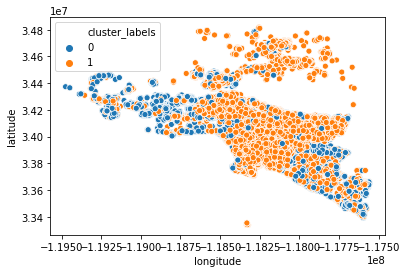

In [32]:
cluster.show_clusters_on_map(two_cluster_df)

### Cluster #1 kinda predicts LA County

The Lat-Long and the Cluser Labels will be dropped to match the scaling object created when the feature matrix was scaled

In [33]:
cluster_labels = two_cluster_df.cluster_labels
two_cluster_df.drop('cluster_labels',axis=1,inplace=True)
two_cluster_df.drop(['latitude','longitude'],axis=1,inplace=True)

The dataframe is unscaled for human readibility when comparing the two clusters

In [34]:
scaler, unscaled_df = cluster.my_inv_transform(std_object, two_cluster_df)

Labels are re-attached

In [35]:
unscaled_df['cluster_labels'] = cluster_labels

In [39]:
unscaled_df['logerror'] = log_error

### EXPLORE THOSE CLUSTERS

Breakdown of mean values for all fields of each cluster.

In [40]:
unscaled_df.groupby('cluster_labels').mean()

,ac_type_id,bathroom_cnt,bedroom_cnt,sum_bath_and_bed,square_feet,heating_type_id,lot_sqr_ft,room_cnt,building_value,total_value,...,tax_amount,has_basement,has_fireplace,has_deck,has_garage,has_pool_or_spa,has_yardbuilding,multistory,home_age,logerror
cluster_labels,,,,,,,,,,,,,,,,,,,,,
0,1.959465,3.134359,3.885909,3.134359,2723.154901,2.165213,13028.550491,4.118918,355205.420493,915228.174757,...,10743.201808,0.002139,0.398991,0.028523,0.669354,0.373430,0.101530,0.325983,36.523065,0.024482
1,1.044749,2.010090,2.743725,2.010090,1443.099360,3.587962,33404.189682,0.687523,134176.525613,345412.299177,...,4359.411006,0.000201,0.016886,0.001500,0.100439,0.175284,0.009093,0.018368,49.369374,0.013984


The logerror for all observations

In [41]:
unscaled_df.logerror.mean()

0.016609865210700406

The logerror for each cluster

In [42]:
unscaled_df.groupby('cluster_labels').logerror.mean()

cluster_labels
0    0.024482
1    0.013984
Name: logerror, dtype: float64

Re-attaching the fips_code to see how the clusters fit in the city codes.

In [43]:
unscaled_df['fips_code'] = fips_code

In [44]:
fips_code.value_counts()

6037.0    46910
6059.0    19951
6111.0     6030
Name: fips_code, dtype: int64

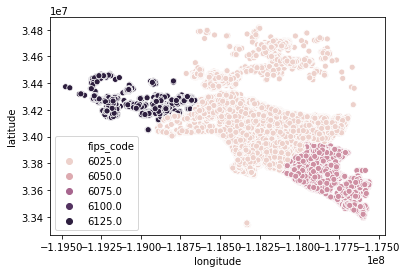

In [45]:
cluster.show_clusters_on_map(unscaled_df, cluster_label='fips_code')

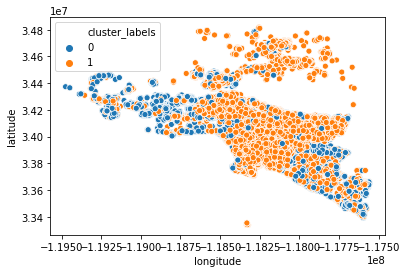

In [46]:
cluster.show_clusters_on_map(unscaled_df, cluster_label='cluster_labels')

In [47]:
big_cluster = unscaled_df[unscaled_df.cluster_labels == 0]

In [48]:
lil_cluster = unscaled_df[unscaled_df.cluster_labels == 1]

In [49]:
stats.ttest_1samp(big_cluster.logerror, unscaled_df.logerror.mean())

Ttest_1sampResult(statistic=5.618773996902357, pvalue=1.9512748977232843e-08)

In [50]:
stats.ttest_1samp(lil_cluster.logerror, unscaled_df.logerror.mean())

Ttest_1sampResult(statistic=-4.011452226694145, pvalue=6.042660037814725e-05)

## UNSCALED DF is ZILLOW, but with Cluster Labels (0,1)

In [51]:
export_csv = unscaled_df.to_csv (r'/Users/fredricklambuth/Projects/Zillow-logerror/labeled_data.csv', index = None, header=True)